In [11]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Initialize dictionary to hold data
# df = {}
# activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# # Load data for each activity into the dictionary
# for activity in activities:
#     df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_1.csv")

# # Create subplots to visualize waveforms
# fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharey=True)

# for i, activity in enumerate(activities):
#     # Plot the waveform for each activity
#     axes[i].plot(df[activity].iloc[:, 0])  # Assuming waveform data is in the first column
#     axes[i].set_title(activity)
#     axes[i].set_xlabel('Time')
#     if i == 0:
#         axes[i].set_ylabel('Amplitude')

# plt.tight_layout()
# plt.show()


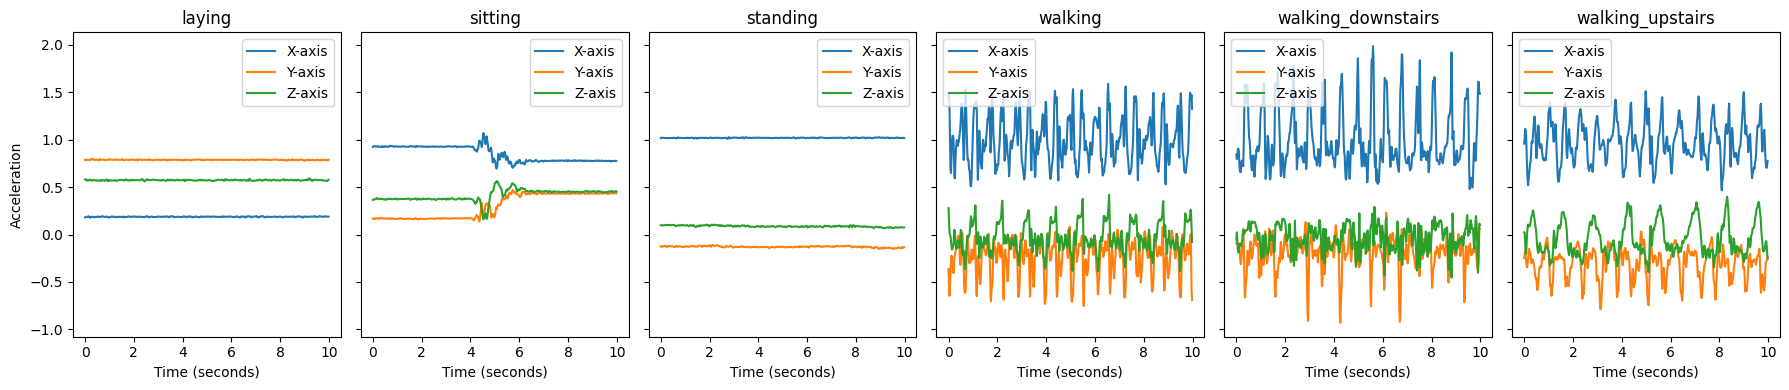

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize dictionary to hold data
df = {}
activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# Load data for each activity into the dictionary
for activity in activities:
    df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_1.csv")

# Create subplots to visualize waveforms
fig, axes = plt.subplots(1, 6, figsize=(18, 4), sharey=True)

# Define the number of samples to plot (corresponding to 10 seconds at 50Hz)
num_samples = 500
sampling_rate = 50  # 50Hz

for i, activity in enumerate(activities):
    # Extract the first 500 samples for each activity
    data = df[activity].iloc[:num_samples]
    # Extract x, y, z components
    x = data.iloc[:, 0]
    y = data.iloc[:, 1]
    z = data.iloc[:, 2]

    # Create time axis in seconds
    time = range(num_samples)  # 0 to 499 samples
    time_seconds = [t / sampling_rate for t in time]  # Convert samples to seconds

    # Plot the waveform for each activity
    axes[i].plot(time_seconds, x, label='X-axis')
    axes[i].plot(time_seconds, y, label='Y-axis')
    axes[i].plot(time_seconds, z, label='Z-axis')
    axes[i].set_title(activity)
    axes[i].set_xlabel('Time (seconds)')
    if i == 0:
        axes[i].set_ylabel('Acceleration')
    axes[i].legend()

plt.tight_layout()
plt.show()
